In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline

In [2]:
cutoffswitch = True

<h3>Initialization</h3>

In [4]:
@jit
def initializeRP(N,M,T,a):
    
    # Initialize positions, r
    r = np.zeros((N,3))
    unit_cell = np.array([[0.0, 0.0, 0.0],[0.5*a, 0.5*a, 0.0],[0.5*a, 0.0, 0.5*a],[0.0, 0.5*a, 0.5*a]]) # Position of atoms on the unit cell
    
    # Place particles on the lattice
    n = 0                                             # Number of particles placed so far
    for i in range(M):
        for j in range(M):
            for k in range(M):
                for l in range(4):
                    if n<N:
                        r[n,:] = unit_cell[l,:] + [i*a, j*a, k*a]
                        n += 1
    
    # Initialize momenta of particles, p
    p = np.random.normal(0, (kb*T*mass)**(1/2), (N,3))
    
    # Correct for drift of center of mass
    vCM = np.sum(p,0)/(N*mass)                        # Velocity of center of mass
    p -= -vCM*mass
    
    # Rescale the velocity to agree with the temperature
    p = p * (((N-1)*3*kb*T)/ (np.sum(p*p)/mass))**(1/2)
    
    return r, p

<h3>Force Calculation</h3>

In [5]:
@jit
def computeForce(r,N,L_box):
    force = np.zeros((N,3))
    r_cutsqrd = r_cut*r_cut
    potential = 0
    
    for i in range(N-1):
        for j in range((i+1),N):
            rij_x = r[i,0]-r[j,0]
            rij_y = r[i,1]-r[j,1]
            rij_z = r[i,2]-r[j,2]
            
            rij_x -= np.rint(rij_x/L_box)*L_box
            rij_y -= np.rint(rij_y/L_box)*L_box
            rij_z -= np.rint(rij_z/L_box)*L_box
            
            r_sqrd = rij_x*rij_x + rij_y*rij_y + rij_z*rij_z
            
            if (r_sqrd < r_cutsqrd or cutoffswitch):
                F = 12*((1/r_sqrd)**7 -(1/r_sqrd)**4)
                potential += (1/r_sqrd)**6 -2*(1/r_sqrd)**3
                
                force[i,0] += rij_x*F
                force[j,0] -= rij_x*F
                
                force[i,1] += rij_y*F
                force[j,1] -= rij_y*F
                
                force[i,2] += rij_z*F
                force[j,2] -= rij_z*F
                
    return force, potential

<h3>Simulations</h3>

<h4>Canonical Ensemble</h4>

In [6]:
def simulate(N,M,T,a,L_box,dt,nsteps,energyPlot=True,momentumComp=True):
    
    E_kin = np.zeros(nsteps)
    E_pot = np.zeros(nsteps)
    
    [r, p] = initializeRP(N,M,T,a)
    r0 = r
    p0 = p
    
    force = computeForce(r,N,L_box)[0]
    
    for i in range(nsteps):
        
        # Verlet applied to position of particle and first part of momentum
        p += (dt/2)*force
        r += p*dt
        r = r % L_box #Places particles back into box
        
        # Compute new force
        force, E_pot[i] = computeForce(r,N,L_box)
        
        # Second part of momentum, using Verlet
        p += 0.5*force*dt
        
        E_kin[i] = 0.5*np.sum(p*p)
    
    if energyPlot:
        plt.figure()
        plt.plot(range(nsteps),(E_kin+E_pot), label='Total Energy')
        plt.plot(range(nsteps),E_pot, label='Potential Energy')
        plt.plot(range(nsteps),E_kin, label='Kinetic Energy')
        plt.legend(loc='upper right')
        plt.show()
    
    if momentumComp:
        print('Initial momentum:', np.sum(p0,0)/N)
        print('Final momentum:', np.sum(p,0)/N)
        print('Difference in momentum:', np.sum(p0,0)/N-np.sum(p,0)/N )
        
    

<h3>Constants and initial parameters </h3>

In [46]:
# Physical parameters in natural units
mass = 1          # Mass of an Argon atom
sigma = 1         # Position of potential well; U(sigma) = -epsilon
epsilon = 1       # Depth of potential well.
kb = 1            # Boltzmann constant
T = 1             # Temperature. T = (temperature in Kelvin) / 119.8 

# Units of time
tau = ((mass/epsilon) * sigma**2) ** (1/2) # Unit of time
dt = 4e-3 * tau                            # Size of time step ~ 1e-14 s
nsteps = 2000                              # Number of timesteps

# Cut-off distance
r_cut = 3*sigma

#System size
N = 256         # Number of particles

#Choose a or density:
# a:
a = 1.27*sigma          # Unit cell size
density = 4/(a**3)     # Density, number of atoms / sigma^3
# density:

""" density = 1            # Density, number of atoms / sigma^3
a = (4/density)**(1/3) # Unit cell size """

# Number of unit cells
M = 1                  # Number of unit cell in one direction
while (4*(M**3)) < N:
    M += 1
L_box = M*a            # Length of sides of box


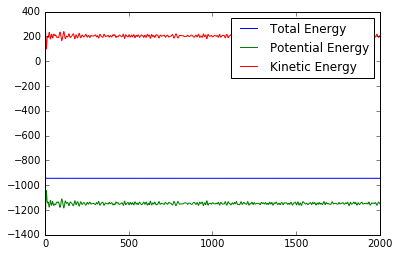

Initial momentum: [-0.37457748  0.07037423  0.120367  ]
Final momentum: [-0.37457748  0.07037423  0.120367  ]
Difference in momentum: [ 0.  0.  0.]


In [47]:
simulate(N,M,T,a,L_box,dt,nsteps)